In [1]:
__file__ = "lanegcn_pimp.py"

import matplotlib.pylab as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# Copyright (c) 2020 Uber Technologies, Inc.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import os
import sys
from fractions import gcd
from numbers import Number

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from data import ArgoDataset, collate_fn
from utils import gpu, to_long,  Optimizer, StepLR

from layers import Conv1d, Res1d, Linear, LinearRes, Null
from numpy import float64, ndarray
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

from pit.dynamics.kinematic_bicycle import Bicycle
from pit.integration import Euler, RK4

file_path = os.path.abspath(__file__)
root_path = os.path.dirname(file_path)
model_name = os.path.basename(file_path).split(".")[0]

### config ###
config = dict()
"""Train"""
config["display_iters"] = 205942
config["val_iters"] = 205942 * 2
config["save_freq"] = 1.0
config["epoch"] = 0
config["horovod"] = False
config["opt"] = "adam"
config["num_epochs"] = 36
config["lr"] = [1e-3, 1e-4]
config["lr_epochs"] = [32]
config["lr_func"] = StepLR(config["lr"], config["lr_epochs"])


if "save_dir" not in config:
    config["save_dir"] = os.path.join(
        root_path, "results", model_name
    )

if not os.path.isabs(config["save_dir"]):
    config["save_dir"] = os.path.join(root_path, "results", config["save_dir"])

config["batch_size"] = 32
config["val_batch_size"] = 32
config["workers"] = 0
config["val_workers"] = config["workers"]


"""Dataset"""
# Raw Dataset
config["train_split"] = os.path.join(
    root_path, "dataset/train/data"
)
config["val_split"] = os.path.join(root_path, "dataset/val/data")
config["test_split"] = os.path.join(root_path, "dataset/test_obs/data")

# Preprocessed Dataset
config["preprocess"] = True # whether use preprocess or not
config["preprocess_train"] = os.path.join(
    root_path, "dataset","preprocess", "train_crs_dist6_angle90.p"
)
config["preprocess_val"] = os.path.join(
    root_path,"dataset", "preprocess", "val_crs_dist6_angle90.p"
)
config['preprocess_test'] = os.path.join(root_path, "dataset",'preprocess', 'test_test.p')

"""Model"""
config["rot_aug"] = False
config["pred_range"] = [-100.0, 100.0, -100.0, 100.0]
config["num_scales"] = 6
config["n_actor"] = 128
config["n_map"] = 128
config["actor2map_dist"] = 7.0
config["map2actor_dist"] = 6.0
config["actor2actor_dist"] = 100.0
config["pred_size"] = 30
config["pred_step"] = 1
config["num_preds"] = config["pred_size"] // config["pred_step"]
config["num_mods"] = 6
config["cls_coef"] = 1.0
config["reg_coef"] = 1.0
config["mgn"] = 0.2
config["cls_th"] = 2.0
config["cls_ignore"] = 0.2
config["wheelbase"] = 4
config["timestep"] = 0.1
### end of config ###

class Net(nn.Module):
    """
    Lane Graph Network contains following components:
        1. ActorNet: a 1D CNN to process the trajectory input
        2. MapNet: LaneGraphCNN to learn structured map representations 
           from vectorized map data
        3. Actor-Map Fusion Cycle: fuse the information between actor nodes 
           and lane nodes:
            a. A2M: introduces real-time traffic information to 
                lane nodes, such as blockage or usage of the lanes
            b. M2M:  updates lane node features by propagating the 
                traffic information over lane graphs
            c. M2A: fuses updated map features with real-time traffic 
                information back to actors
            d. A2A: handles the interaction between actors and produces
                the output actor features
        4. PredNet: prediction header for motion forecasting using 
           feature from A2A
    """
    def __init__(self, config):
        super(Net, self).__init__()
        self.config = config

        self.actor_net = ActorNet(config)
        self.map_net = MapNet(config)

        self.a2m = A2M(config)
        self.m2m = M2M(config)
        self.m2a = M2A(config)
        self.a2a = A2A(config)

        self.pred_net = PredNet(config)

    def forward(self, data: Dict) -> Dict[str, List[Tensor]]:
        # construct actor feature
        actors, actor_idcs = actor_gather(gpu(data["feats"]))
        actor_ctrs = gpu(data["ctrs"])
        actors = self.actor_net(actors)

        # construct map features
        graph = graph_gather(to_long(gpu(data["graph"])))
        nodes, node_idcs, node_ctrs = self.map_net(graph)

        # actor-map fusion cycle 
        nodes = self.a2m(nodes, graph, actors, actor_idcs, actor_ctrs)
        nodes = self.m2m(nodes, graph)
        actors = self.m2a(actors, actor_idcs, actor_ctrs, nodes, node_idcs, node_ctrs)
        actors = self.a2a(actors, actor_idcs, actor_ctrs)

        # prediction
        out = self.pred_net(actors, actor_idcs, actor_ctrs, data['feats'])
        rot, orig = gpu(data["rot"]), gpu(data["orig"])
        # transform prediction to world coordinates
        for i in range(len(out["reg"])):
            out["reg"][i] = torch.matmul(out["reg"][i], rot[i]) + orig[i].view(
                1, 1, 1, -1
            )
        return out


def actor_gather(actors: List[Tensor]) -> Tuple[Tensor, List[Tensor]]:
    batch_size = len(actors)
    num_actors = [len(x) for x in actors]

    actors = [x.transpose(1, 2) for x in actors]
    actors = torch.cat(actors, 0)

    actor_idcs = []
    count = 0
    for i in range(batch_size):
        idcs = torch.arange(count, count + num_actors[i]).to(actors.device)
        actor_idcs.append(idcs)
        count += num_actors[i]
    return actors, actor_idcs


def graph_gather(graphs):
    batch_size = len(graphs)
    node_idcs = []
    count = 0
    counts = []
    for i in range(batch_size):
        counts.append(count)
        idcs = torch.arange(count, count + graphs[i]["num_nodes"]).to(
            graphs[i]["feats"].device
        )
        node_idcs.append(idcs)
        count = count + graphs[i]["num_nodes"]

    graph = dict()
    graph["idcs"] = node_idcs
    graph["ctrs"] = [x["ctrs"] for x in graphs]

    for key in ["feats", "turn", "control", "intersect"]:
        graph[key] = torch.cat([x[key] for x in graphs], 0)

    for k1 in ["pre", "suc"]:
        graph[k1] = []
        for i in range(len(graphs[0]["pre"])):
            graph[k1].append(dict())
            for k2 in ["u", "v"]:
                graph[k1][i][k2] = torch.cat(
                    [graphs[j][k1][i][k2] + counts[j] for j in range(batch_size)], 0
                )

    for k1 in ["left", "right"]:
        graph[k1] = dict()
        for k2 in ["u", "v"]:
            temp = [graphs[i][k1][k2] + counts[i] for i in range(batch_size)]
            temp = [
                x if x.dim() > 0 else graph["pre"][0]["u"].new().resize_(0)
                for x in temp
            ]
            graph[k1][k2] = torch.cat(temp)
    return graph


class ActorNet(nn.Module):
    """
    Actor feature extractor with Conv1D
    """
    def __init__(self, config):
        super(ActorNet, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1

        n_in = 3
        n_out = [32, 64, 128]
        blocks = [Res1d, Res1d, Res1d]
        num_blocks = [2, 2, 2]

        groups = []
        for i in range(len(num_blocks)):
            group = []
            if i == 0:
                group.append(blocks[i](n_in, n_out[i], norm=norm, ng=ng))
            else:
                group.append(blocks[i](n_in, n_out[i], stride=2, norm=norm, ng=ng))

            for j in range(1, num_blocks[i]):
                group.append(blocks[i](n_out[i], n_out[i], norm=norm, ng=ng))
            groups.append(nn.Sequential(*group))
            n_in = n_out[i]
        self.groups = nn.ModuleList(groups)

        n = config["n_actor"]
        lateral = []
        for i in range(len(n_out)):
            lateral.append(Conv1d(n_out[i], n, norm=norm, ng=ng, act=False))
        self.lateral = nn.ModuleList(lateral)

        self.output = Res1d(n, n, norm=norm, ng=ng)

    def forward(self, actors: Tensor) -> Tensor:
        out = actors

        outputs = []
        for i in range(len(self.groups)):
            out = self.groups[i](out)
            outputs.append(out)

        out = self.lateral[-1](outputs[-1])
        for i in range(len(outputs) - 2, -1, -1):
            out = F.interpolate(out, scale_factor=2, mode="linear", align_corners=False)
            out += self.lateral[i](outputs[i])

        out = self.output(out)[:, :, -1]
        return out


class MapNet(nn.Module):
    """
    Map Graph feature extractor with LaneGraphCNN
    """
    def __init__(self, config):
        super(MapNet, self).__init__()
        self.config = config
        n_map = config["n_map"]
        norm = "GN"
        ng = 1

        self.input = nn.Sequential(
            nn.Linear(2, n_map),
            nn.ReLU(inplace=True),
            Linear(n_map, n_map, norm=norm, ng=ng, act=False),
        )
        self.seg = nn.Sequential(
            nn.Linear(2, n_map),
            nn.ReLU(inplace=True),
            Linear(n_map, n_map, norm=norm, ng=ng, act=False),
        )

        keys = ["ctr", "norm", "ctr2", "left", "right"]
        for i in range(config["num_scales"]):
            keys.append("pre" + str(i))
            keys.append("suc" + str(i))

        fuse = dict()
        for key in keys:
            fuse[key] = []

        for i in range(4):
            for key in fuse:
                if key in ["norm"]:
                    fuse[key].append(nn.GroupNorm(gcd(ng, n_map), n_map))
                elif key in ["ctr2"]:
                    fuse[key].append(Linear(n_map, n_map, norm=norm, ng=ng, act=False))
                else:
                    fuse[key].append(nn.Linear(n_map, n_map, bias=False))

        for key in fuse:
            fuse[key] = nn.ModuleList(fuse[key])
        self.fuse = nn.ModuleDict(fuse)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, graph):
        if (
            len(graph["feats"]) == 0
            or len(graph["pre"][-1]["u"]) == 0
            or len(graph["suc"][-1]["u"]) == 0
        ):
            temp = graph["feats"]
            return (
                temp.new().resize_(0),
                [temp.new().long().resize_(0) for x in graph["node_idcs"]],
                temp.new().resize_(0),
            )

        ctrs = torch.cat(graph["ctrs"], 0)
        feat = self.input(ctrs)
        feat += self.seg(graph["feats"])
        feat = self.relu(feat)

        """fuse map"""
        res = feat
        for i in range(len(self.fuse["ctr"])):
            temp = self.fuse["ctr"][i](feat)
            for key in self.fuse:
                if key.startswith("pre") or key.startswith("suc"):
                    k1 = key[:3]
                    k2 = int(key[3:])
                    temp.index_add_(
                        0,
                        graph[k1][k2]["u"],
                        self.fuse[key][i](feat[graph[k1][k2]["v"]]),
                    )

            if len(graph["left"]["u"] > 0):
                temp.index_add_(
                    0,
                    graph["left"]["u"],
                    self.fuse["left"][i](feat[graph["left"]["v"]]),
                )
            if len(graph["right"]["u"] > 0):
                temp.index_add_(
                    0,
                    graph["right"]["u"],
                    self.fuse["right"][i](feat[graph["right"]["v"]]),
                )

            feat = self.fuse["norm"][i](temp)
            feat = self.relu(feat)

            feat = self.fuse["ctr2"][i](feat)
            feat += res
            feat = self.relu(feat)
            res = feat
        return feat, graph["idcs"], graph["ctrs"]


class A2M(nn.Module):
    """
    Actor to Map Fusion:  fuses real-time traffic information from
    actor nodes to lane nodes
    """
    def __init__(self, config):
        super(A2M, self).__init__()
        self.config = config
        n_map = config["n_map"]
        norm = "GN"
        ng = 1

        """fuse meta, static, dyn"""
        self.meta = Linear(n_map + 4, n_map, norm=norm, ng=ng)
        att = []
        for i in range(2):
            att.append(Att(n_map, config["n_actor"]))
        self.att = nn.ModuleList(att)

    def forward(self, feat: Tensor, graph: Dict[str, Union[List[Tensor], Tensor, List[Dict[str, Tensor]], Dict[str, Tensor]]], actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor]) -> Tensor:
        """meta, static and dyn fuse using attention"""
        meta = torch.cat(
            (
                graph["turn"],
                graph["control"].unsqueeze(1),
                graph["intersect"].unsqueeze(1),
            ),
            1,
        )
        feat = self.meta(torch.cat((feat, meta), 1))

        for i in range(len(self.att)):
            feat = self.att[i](
                feat,
                graph["idcs"],
                graph["ctrs"],
                actors,
                actor_idcs,
                actor_ctrs,
                self.config["actor2map_dist"],
            )
        return feat


class M2M(nn.Module):
    """
    The lane to lane block: propagates information over lane
            graphs and updates the features of lane nodes
    """
    def __init__(self, config):
        super(M2M, self).__init__()
        self.config = config
        n_map = config["n_map"]
        norm = "GN"
        ng = 1

        keys = ["ctr", "norm", "ctr2", "left", "right"]
        for i in range(config["num_scales"]):
            keys.append("pre" + str(i))
            keys.append("suc" + str(i))

        fuse = dict()
        for key in keys:
            fuse[key] = []

        for i in range(4):
            for key in fuse:
                if key in ["norm"]:
                    fuse[key].append(nn.GroupNorm(gcd(ng, n_map), n_map))
                elif key in ["ctr2"]:
                    fuse[key].append(Linear(n_map, n_map, norm=norm, ng=ng, act=False))
                else:
                    fuse[key].append(nn.Linear(n_map, n_map, bias=False))

        for key in fuse:
            fuse[key] = nn.ModuleList(fuse[key])
        self.fuse = nn.ModuleDict(fuse)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, feat: Tensor, graph: Dict) -> Tensor:
        """fuse map"""
        res = feat
        for i in range(len(self.fuse["ctr"])):
            temp = self.fuse["ctr"][i](feat)
            for key in self.fuse:
                if key.startswith("pre") or key.startswith("suc"):
                    k1 = key[:3]
                    k2 = int(key[3:])
                    temp.index_add_(
                        0,
                        graph[k1][k2]["u"],
                        self.fuse[key][i](feat[graph[k1][k2]["v"]]),
                    )

            if len(graph["left"]["u"] > 0):
                temp.index_add_(
                    0,
                    graph["left"]["u"],
                    self.fuse["left"][i](feat[graph["left"]["v"]]),
                )
            if len(graph["right"]["u"] > 0):
                temp.index_add_(
                    0,
                    graph["right"]["u"],
                    self.fuse["right"][i](feat[graph["right"]["v"]]),
                )

            feat = self.fuse["norm"][i](temp)
            feat = self.relu(feat)

            feat = self.fuse["ctr2"][i](feat)
            feat += res
            feat = self.relu(feat)
            res = feat
        return feat


class M2A(nn.Module):
    """
    The lane to actor block fuses updated
        map information from lane nodes to actor nodes
    """
    def __init__(self, config):
        super(M2A, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1

        n_actor = config["n_actor"]
        n_map = config["n_map"]

        att = []
        for i in range(2):
            att.append(Att(n_actor, n_map))
        self.att = nn.ModuleList(att)

    def forward(self, actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor], nodes: Tensor, node_idcs: List[Tensor], node_ctrs: List[Tensor]) -> Tensor:
        for i in range(len(self.att)):
            actors = self.att[i](
                actors,
                actor_idcs,
                actor_ctrs,
                nodes,
                node_idcs,
                node_ctrs,
                self.config["map2actor_dist"],
            )
        return actors


class A2A(nn.Module):
    """
    The actor to actor block performs interactions among actors.
    """
    def __init__(self, config):
        super(A2A, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1

        n_actor = config["n_actor"]
        n_map = config["n_map"]

        att = []
        for i in range(2):
            att.append(Att(n_actor, n_actor))
        self.att = nn.ModuleList(att)

    def forward(self, actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor]) -> Tensor:
        for i in range(len(self.att)):
            actors = self.att[i](
                actors,
                actor_idcs,
                actor_ctrs,
                actors,
                actor_idcs,
                actor_ctrs,
                self.config["actor2actor_dist"],
            )
        return actors


class EncodeDist(nn.Module):
    def __init__(self, n, linear=True):
        super(EncodeDist, self).__init__()
        norm = "GN"
        ng = 1

        block = [nn.Linear(2, n), nn.ReLU(inplace=True)]

        if linear:
            block.append(nn.Linear(n, n))

        self.block = nn.Sequential(*block)

    def forward(self, dist):
        x, y = dist[:, :1], dist[:, 1:]
        dist = torch.cat(
            (
                torch.sign(x) * torch.log(torch.abs(x) + 1.0),
                torch.sign(y) * torch.log(torch.abs(y) + 1.0),
            ),
            1,
        )

        dist = self.block(dist)
        return dist


class PhysicsHeader(nn.Module):
    def __init__(self, config):
        super(PhysicsHeader, self).__init__()
        self.config = config
        
        norm = "GN"
        ng = 1
        n_actor = config["n_actor"]
        
        self.net = nn.Sequential(
            LinearRes(n_actor, n_actor, norm=norm, ng=ng),
            nn.Linear(n_actor, 2 * config["num_preds"]),
        )
        self.dynamics = Euler(Bicycle(config["wheelbase"]), timestep=config["timestep"])
    
    @staticmethod
    def _get_two_point_orientation(p1: (float, float), p2: (float, float)) -> float:
        """Get angle orientation between these two points in radians"""
        x, y = [p2[0]-p1[0], p2[1]-p1[1]]
        return torch.arctan2(y, x)
    
    def _get_speeds(self, positions):
        """
        Get speeds of actors
        
        Input:
            positions(np.ndarray): shape: (ACTORS, TIMESTEPS, (X,Y))
        """
        speeds = [[torch.linalg.norm(positions[actor,timestep]-positions[actor,timestep+1])/config["timestep"] for timestep in range(positions.shape[1]-1)] for actor in range(positions.shape[0])]
        speeds = torch.tensor(speeds)
        speeds = torch.mean(speeds, dim=-1)
        return speeds
        
    def _get_headings(self, positions):
        headings = [[self._get_two_point_orientation(positions[actor,timestep], positions[actor,timestep+1]) for timestep in range(positions.shape[1]-1)] for actor in range(positions.shape[0])]
        headings = torch.tensor(headings)
        headings = torch.mean(headings, dim=-1)
        return headings
    
    def _assemble_states(self, features):
        features = features.permute(0,2,1)
        ACTORS, STEPS, _ = features.shape
        positions = [[(features[actor_idx,timestep,0],
                       features[actor_idx,timestep,1]) for timestep in range(-2,0,1)] for actor_idx in range(features.shape[0])]
        positions = torch.tensor(positions)
        speeds = self._get_speeds(positions)
        headings = self._get_headings(positions)
        STATE_DIMS = 4  # From Bicycle Model
        states = torch.zeros((ACTORS, STATE_DIMS))
        for actor in range(ACTORS):
            states[actor, 0] = positions[actor, -1, 0]
            states[actor, 1] = positions[actor, -1, 1]
            states[actor, 2] = headings[actor]
            states[actor, 3] = speeds[actor]
        return gpu(states)
    
    def forward(self, actors, features):
        ACTORS, _ = actors.shape
        initial_states = self._assemble_states(features)
        control_inputs = self.net(actors)
        control_inputs = control_inputs.reshape((ACTORS, config["num_preds"], 2))
        integrated_states = self.dynamics(initial_states, control_inputs)
        output_states = integrated_states[:,:,2]
        return output_states
    
class PredNet(nn.Module):
    """
    Final motion forecasting with Linear Residual block
    """
    def __init__(self, config):
        super(PredNet, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1

        n_actor = config["n_actor"]

        pred = []
        for i in range(config["num_mods"]):
            pred.append(
                PhysicsHeader(config)
            )
        self.pred = nn.ModuleList(pred)

        self.att_dest = AttDest(n_actor)
        self.cls = nn.Sequential(
            LinearRes(n_actor, n_actor, norm=norm, ng=ng), nn.Linear(n_actor, 1)
        )

    def forward(self, actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor], features: List[Tensor]) -> Dict[str, List[Tensor]]:
        afeats, afeats_idcs = actor_gather(gpu(features))
        preds = []
        for i in range(len(self.pred)):
            preds.append(self.pred[i](actors, afeats))
        reg = torch.cat([x.unsqueeze(1) for x in preds], 1)
        reg = reg.view(reg.size(0), reg.size(1), -1, 2)

        for i in range(len(actor_idcs)):
            idcs = actor_idcs[i]
            ctrs = actor_ctrs[i].view(-1, 1, 1, 2)
            reg[idcs] = reg[idcs] + ctrs

        dest_ctrs = reg[:, :, -1].detach()
        feats = self.att_dest(actors, torch.cat(actor_ctrs, 0), dest_ctrs)
        cls = self.cls(feats).view(-1, self.config["num_mods"])

        cls, sort_idcs = cls.sort(1, descending=True)
        row_idcs = torch.arange(len(sort_idcs)).long().to(sort_idcs.device)
        row_idcs = row_idcs.view(-1, 1).repeat(1, sort_idcs.size(1)).view(-1)
        sort_idcs = sort_idcs.view(-1)
        reg = reg[row_idcs, sort_idcs].view(cls.size(0), cls.size(1), -1, 2)

        out = dict()
        out["cls"], out["reg"] = [], []
        for i in range(len(actor_idcs)):
            idcs = actor_idcs[i]
            ctrs = actor_ctrs[i].view(-1, 1, 1, 2)
            out["cls"].append(cls[idcs])
            out["reg"].append(reg[idcs])
        print(out['reg'][0].shape)
        return out


class Att(nn.Module):
    """
    Attention block to pass context nodes information to target nodes
    This is used in Actor2Map, Actor2Actor, Map2Actor and Map2Map
    """
    def __init__(self, n_agt: int, n_ctx: int) -> None:
        super(Att, self).__init__()
        norm = "GN"
        ng = 1

        self.dist = nn.Sequential(
            nn.Linear(2, n_ctx),
            nn.ReLU(inplace=True),
            Linear(n_ctx, n_ctx, norm=norm, ng=ng),
        )

        self.query = Linear(n_agt, n_ctx, norm=norm, ng=ng)

        self.ctx = nn.Sequential(
            Linear(3 * n_ctx, n_agt, norm=norm, ng=ng),
            nn.Linear(n_agt, n_agt, bias=False),
        )

        self.agt = nn.Linear(n_agt, n_agt, bias=False)
        self.norm = nn.GroupNorm(gcd(ng, n_agt), n_agt)
        self.linear = Linear(n_agt, n_agt, norm=norm, ng=ng, act=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, agts: Tensor, agt_idcs: List[Tensor], agt_ctrs: List[Tensor], ctx: Tensor, ctx_idcs: List[Tensor], ctx_ctrs: List[Tensor], dist_th: float) -> Tensor:
        res = agts
        if len(ctx) == 0:
            agts = self.agt(agts)
            agts = self.relu(agts)
            agts = self.linear(agts)
            agts += res
            agts = self.relu(agts)
            return agts

        batch_size = len(agt_idcs)
        hi, wi = [], []
        hi_count, wi_count = 0, 0
        for i in range(batch_size):
            dist = agt_ctrs[i].view(-1, 1, 2) - ctx_ctrs[i].view(1, -1, 2)
            dist = torch.sqrt((dist ** 2).sum(2))
            mask = dist <= dist_th

            idcs = torch.nonzero(mask, as_tuple=False)
            if len(idcs) == 0:
                continue

            hi.append(idcs[:, 0] + hi_count)
            wi.append(idcs[:, 1] + wi_count)
            hi_count += len(agt_idcs[i])
            wi_count += len(ctx_idcs[i])
        hi = torch.cat(hi, 0)
        wi = torch.cat(wi, 0)

        agt_ctrs = torch.cat(agt_ctrs, 0)
        ctx_ctrs = torch.cat(ctx_ctrs, 0)
        dist = agt_ctrs[hi] - ctx_ctrs[wi]
        dist = self.dist(dist)

        query = self.query(agts[hi])

        ctx = ctx[wi]
        ctx = torch.cat((dist, query, ctx), 1)
        ctx = self.ctx(ctx)

        agts = self.agt(agts)
        agts.index_add_(0, hi, ctx)
        agts = self.norm(agts)
        agts = self.relu(agts)

        agts = self.linear(agts)
        agts += res
        agts = self.relu(agts)
        return agts


class AttDest(nn.Module):
    def __init__(self, n_agt: int):
        super(AttDest, self).__init__()
        norm = "GN"
        ng = 1

        self.dist = nn.Sequential(
            nn.Linear(2, n_agt),
            nn.ReLU(inplace=True),
            Linear(n_agt, n_agt, norm=norm, ng=ng),
        )

        self.agt = Linear(2 * n_agt, n_agt, norm=norm, ng=ng)

    def forward(self, agts: Tensor, agt_ctrs: Tensor, dest_ctrs: Tensor) -> Tensor:
        n_agt = agts.size(1)
        num_mods = dest_ctrs.size(1)

        dist = (agt_ctrs.unsqueeze(1) - dest_ctrs).view(-1, 2)
        dist = self.dist(dist)
        agts = agts.unsqueeze(1).repeat(1, num_mods, 1).view(-1, n_agt)

        agts = torch.cat((dist, agts), 1)
        agts = self.agt(agts)
        return agts


class PredLoss(nn.Module):
    def __init__(self, config):
        super(PredLoss, self).__init__()
        self.config = config
        self.reg_loss = nn.SmoothL1Loss(reduction="sum")

    def forward(self, out: Dict[str, List[Tensor]], gt_preds: List[Tensor], has_preds: List[Tensor]) -> Dict[str, Union[Tensor, int]]:
        cls, reg = out["cls"], out["reg"]
        cls = torch.cat([x for x in cls], 0)
        reg = torch.cat([x for x in reg], 0)
        gt_preds = torch.cat([x for x in gt_preds], 0)
        has_preds = torch.cat([x for x in has_preds], 0)

        loss_out = dict()
        zero = 0.0 * (cls.sum() + reg.sum())
        loss_out["cls_loss"] = zero.clone()
        loss_out["num_cls"] = 0
        loss_out["reg_loss"] = zero.clone()
        loss_out["num_reg"] = 0

        num_mods, num_preds = self.config["num_mods"], self.config["num_preds"]
        # assert(has_preds.all())

        last = has_preds.float() + 0.1 * torch.arange(num_preds).float().to(
            has_preds.device
        ) / float(num_preds)
        max_last, last_idcs = last.max(1)
        mask = max_last > 1.0

        cls = cls[mask]
        reg = reg[mask]
        gt_preds = gt_preds[mask]
        has_preds = has_preds[mask]
        last_idcs = last_idcs[mask]

        row_idcs = torch.arange(len(last_idcs)).long().to(last_idcs.device)
        dist = []
        for j in range(num_mods):
            dist.append(
                torch.sqrt(
                    (
                        (reg[row_idcs, j, last_idcs] - gt_preds[row_idcs, last_idcs])
                        ** 2
                    ).sum(1)
                )
            )
        dist = torch.cat([x.unsqueeze(1) for x in dist], 1)
        min_dist, min_idcs = dist.min(1)
        row_idcs = torch.arange(len(min_idcs)).long().to(min_idcs.device)

        mgn = cls[row_idcs, min_idcs].unsqueeze(1) - cls
        mask0 = (min_dist < self.config["cls_th"]).view(-1, 1)
        mask1 = dist - min_dist.view(-1, 1) > self.config["cls_ignore"]
        mgn = mgn[mask0 * mask1]
        mask = mgn < self.config["mgn"]
        coef = self.config["cls_coef"]
        loss_out["cls_loss"] += coef * (
            self.config["mgn"] * mask.sum() - mgn[mask].sum()
        )
        loss_out["num_cls"] += mask.sum().item()

        reg = reg[row_idcs, min_idcs]
        coef = self.config["reg_coef"]
        loss_out["reg_loss"] += coef * self.reg_loss(
            reg[has_preds], gt_preds[has_preds]
        )
        loss_out["num_reg"] += has_preds.sum().item()
        return loss_out


class Loss(nn.Module):
    def __init__(self, config):
        super(Loss, self).__init__()
        self.config = config
        self.pred_loss = PredLoss(config)

    def forward(self, out: Dict, data: Dict) -> Dict:
        loss_out = self.pred_loss(out, gpu(data["gt_preds"]), gpu(data["has_preds"]))
        loss_out["loss"] = loss_out["cls_loss"] / (
            loss_out["num_cls"] + 1e-10
        ) + loss_out["reg_loss"] / (loss_out["num_reg"] + 1e-10)
        return loss_out


class PostProcess(nn.Module):
    def __init__(self, config):
        super(PostProcess, self).__init__()
        self.config = config

    def forward(self, out,data):
        post_out = dict()
        post_out["preds"] = [x[0:1].detach().cpu().numpy() for x in out["reg"]]
        post_out["gt_preds"] = [x[0:1].numpy() for x in data["gt_preds"]]
        post_out["has_preds"] = [x[0:1].numpy() for x in data["has_preds"]]
        return post_out

    def append(self, metrics: Dict, loss_out: Dict, post_out: Optional[Dict[str, List[ndarray]]]=None) -> Dict:
        if len(metrics.keys()) == 0:
            for key in loss_out:
                if key != "loss":
                    metrics[key] = 0.0

            for key in post_out:
                metrics[key] = []

        for key in loss_out:
            if key == "loss":
                continue
            if isinstance(loss_out[key], torch.Tensor):
                metrics[key] += loss_out[key].item()
            else:
                metrics[key] += loss_out[key]

        for key in post_out:
            metrics[key] += post_out[key]
        return metrics

    def display(self, metrics, dt, epoch, lr=None):
        """Every display-iters print training/val information"""
        if lr is not None:
            print("Epoch %3.3f, lr %.5f, time %3.2f" % (epoch, lr, dt))
        else:
            print(
                "************************* Validation, time %3.2f *************************"
                % dt
            )

        cls = metrics["cls_loss"] / (metrics["num_cls"] + 1e-10)
        reg = metrics["reg_loss"] / (metrics["num_reg"] + 1e-10)
        loss = cls + reg

        preds = np.concatenate(metrics["preds"], 0)
        gt_preds = np.concatenate(metrics["gt_preds"], 0)
        has_preds = np.concatenate(metrics["has_preds"], 0)
        ade1, fde1, ade, fde, min_idcs = pred_metrics(preds, gt_preds, has_preds)

        print(
            "loss %2.4f %2.4f %2.4f, ade1 %2.4f, fde1 %2.4f, ade %2.4f, fde %2.4f"
            % (loss, cls, reg, ade1, fde1, ade, fde)
        )
        print()


def pred_metrics(preds, gt_preds, has_preds):
    assert has_preds.all()
    preds = np.asarray(preds, np.float32)
    gt_preds = np.asarray(gt_preds, np.float32)

    """batch_size x num_mods x num_preds"""
    err = np.sqrt(((preds - np.expand_dims(gt_preds, 1)) ** 2).sum(3))

    ade1 = err[:, 0].mean()
    fde1 = err[:, 0, -1].mean()

    min_idcs = err[:, :, -1].argmin(1)
    row_idcs = np.arange(len(min_idcs)).astype(np.int64)
    err = err[row_idcs, min_idcs]
    ade = err.mean()
    fde = err[:, -1].mean()
    return ade1, fde1, ade, fde, min_idcs


def get_model():
    net = Net(config)
    net = net.cuda()

    loss = Loss(config).cuda()
    post_process = PostProcess(config).cuda()

    params = net.parameters()
    opt = Optimizer(params, config)


    return config, ArgoDataset, collate_fn, net, loss, post_process, opt


/root/miniconda3/envs/lanegcn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()
dataset = Dataset(config["val_split"], config, train=False)


lanegcn_pimp.py:303: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  
lanegcn_pimp.py:725: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  out["cls"].append(cls[idcs])
lanegcn_pimp.py:437: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


In [4]:
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()

lanegcn_pimp.py:303: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  
lanegcn_pimp.py:725: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  out["cls"].append(cls[idcs])
lanegcn_pimp.py:437: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


In [5]:
dataset = Dataset(config["val_split"], config, train=False)

In [6]:
print("{")
for key in dataset[0].keys():
    print("\t", key)
    try:
        for skey in dataset[0][key].keys():
            print("\t\t", skey)
    except:
        pass

{
	 city
	 orig
	 gt_preds
	 has_preds
	 theta
	 rot
	 feats
	 ctrs
	 graph
		 ctrs
		 num_nodes
		 feats
		 turn
		 control
		 intersect
		 pre
		 suc
		 lane_idcs
		 pre_pairs
		 suc_pairs
		 left_pairs
		 right_pairs
		 left
		 right


In [7]:
dataset[0]['city']

'PIT'

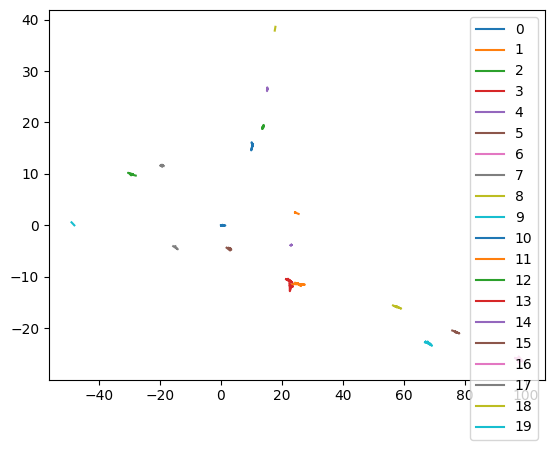

In [8]:
RANGE=10000
for dataidx in [246]:
    for IDX in range(dataset[dataidx]['feats'].shape[0]):
        assert(dataset[dataidx]['feats'].shape[0] == dataset[dataidx]['ctrs'].shape[0])
        plt.plot(dataset[dataidx]['feats'][IDX,:RANGE,0] + dataset[dataidx]['ctrs'][IDX,0],
                 dataset[dataidx]['feats'][IDX,:RANGE,1] + dataset[dataidx]['ctrs'][IDX,1],
                 label=str(IDX))
    plt.legend()
    plt.show()

In [9]:
trajectory = dataset[dataidx]['gt_preds'][9,:]
trajectory.shape

(30, 2)

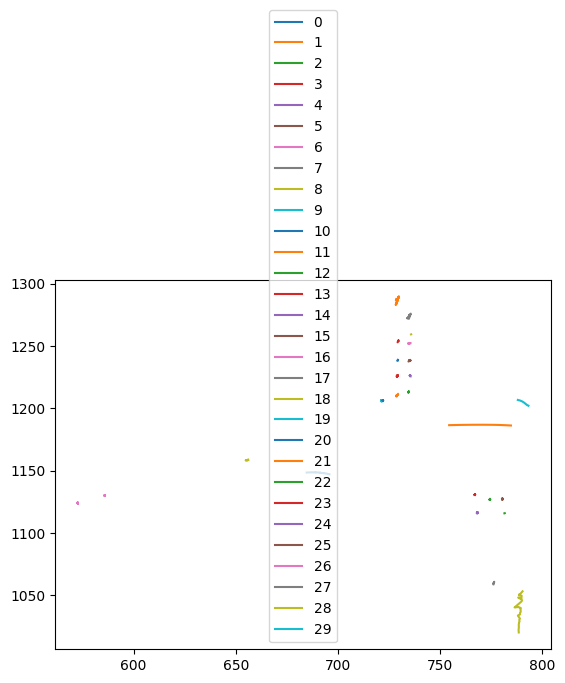

In [10]:
for dataidx in [20]:
    for IDX in range(dataset[dataidx]['gt_preds'].shape[1]):
        trajectory = dataset[dataidx]['gt_preds'][IDX,:]
        trajectory[trajectory == 0] = np.nan
        trajectory[:,0] += dataset[dataidx]['ctrs'][IDX,0]
        trajectory[:,1] += dataset[dataidx]['ctrs'][IDX,1]
        plt.plot(trajectory[:,0],
                 trajectory[:,1],
                 label=str(IDX))
    plt.legend()
    plt.show()

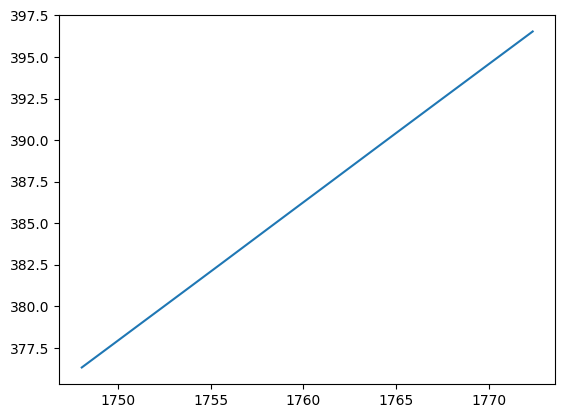

In [11]:
plt.plot(dataset[0]['gt_preds'][1,:,0], dataset[0]['gt_preds'][1,:,1])

In [12]:
dataset[0]['feats'].shape

(15, 20, 3)

In [13]:
torch.tensor(dataset[0]['feats']).shape

torch.Size([15, 20, 3])

In [14]:
for i in range(-3,0,1):
    print(i)

-3
-2
-1


In [15]:
r = np.random.rand(2,3)

In [16]:
np.average(r, axis=-1).shape

(2,)

In [17]:
class PhysicsHeader(nn.Module):
    def __init__(self, config):
        super(PhysicsHeader, self).__init__()
        self.config = config
        
        norm = "GN"
        ng = 1
        n_actor = config["n_actor"]
        
        self.net = nn.Sequential(
            LinearRes(n_actor, n_actor, norm=norm, ng=ng),
            nn.Linear(n_actor, 2 * config["num_preds"]),
        )
        self.dynamics = Euler(Bicycle(config["wheelbase"]), timestep=config["timestep"])
    
    @staticmethod
    def _get_two_point_orientation(p1: (float, float), p2: (float, float)) -> float:
        """Get angle orientation between these two points in radians"""
        x, y = [p2[0]-p1[0], p2[1]-p1[1]]
        return torch.arctan2(y, x)
    
    def _get_speeds(self, positions):
        """
        Get speeds of actors
        
        Input:
            positions(np.ndarray): shape: (ACTORS, TIMESTEPS, (X,Y))
        """
        speeds = [torch.linalg.norm(positions[actor,0]-positions[actor,-1])/config["timestep"] for actor in range(positions.shape[0])]
        speeds = torch.tensor(speeds)
        return speeds
        
    def _get_headings(self, positions):
        headings = [self._get_two_point_orientation(positions[actor, 0], positions[actor, -1]) for actor in range(positions.shape[0])]
        headings = torch.tensor(headings)
        return headings
    
    def _assemble_states(self, features):
        #features = features.permute(0,2,1)
        try:
            assert(features.shape[2]==3 and features.shape[1]==20)
        except AssertionError:
            print(features.shape)
            import ipdb; ipdb.set_trace()
            raise AssertionError
        ACTORS, STEPS, _ = features.shape
        positions = [[(features[actor_idx,timestep,0],
                       features[actor_idx,timestep,1]) for timestep in range(-3,0,1)] for actor_idx in range(features.shape[0])]
        positions = torch.tensor(positions)
        speeds = self._get_speeds(positions)
        headings = self._get_headings(positions)
        STATE_DIMS = 4  # From Bicycle Model
        states = torch.zeros((ACTORS, STATE_DIMS))
        for actor in range(ACTORS):
            states[actor, 0] = positions[actor, -1, 0]
            states[actor, 1] = positions[actor, -1, 1]
            states[actor, 2] = headings[actor]
            states[actor, 3] = speeds[actor]
        return gpu(states)
    
    def forward(self, actors, features):
        ACTORS, _ = actors.shape
        initial_states = self._assemble_states(features)
        control_inputs = self.net(actors)
        control_inputs = control_inputs.reshape((ACTORS, config["num_preds"], 2))
        integrated_states = self.dynamics(initial_states, control_inputs)
        output_states = integrated_states[:,:,:2]
        return output_states

In [18]:
p = PhysicsHeader(config)

In [19]:
features = list(dataset[0]['feats'])
ctrs = list(dataset[0]['ctrs'])

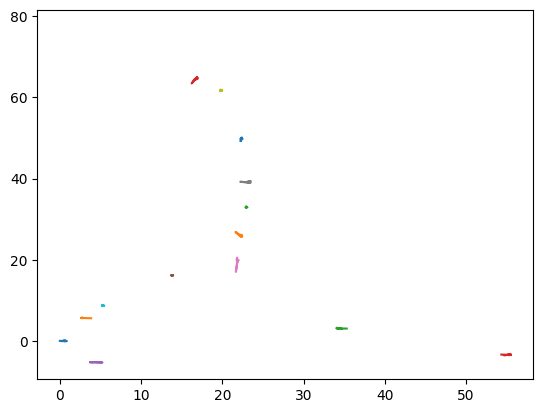

In [20]:
for i in range(len(features)):
    plt.plot(features[i][:,0]+ctrs[i][0], features[i][:,1]+ctrs[i][1])
plt.show()

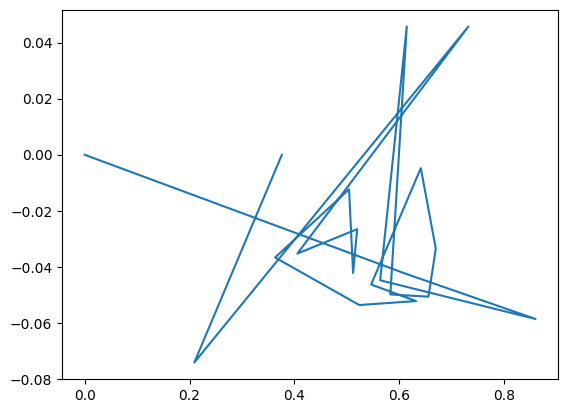

In [21]:
for i in range(1):
    plt.plot(features[i][:,0]+ctrs[i][0], features[i][:,1]+ctrs[i][1])
plt.show()

In [22]:
features = torch.tensor(features)
features.shape

lanegcn_pimp.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484801627/work/torch/csrc/utils/tensor_new.cpp:201.)
  # Copyright (c) 2020 Uber Technologies, Inc.


torch.Size([15, 20, 3])

In [23]:
p._assemble_states(features)

tensor([[ 3.7581e-01, -3.6667e-05, -3.0136e+00,  3.5852e+00],
        [-1.0649e+00,  6.6492e-02,  3.0724e+00,  1.0933e+00],
        [-8.5366e-01,  2.1876e-02, -3.1330e-01,  3.0458e+00],
        [ 1.1609e+00, -7.5888e-02, -5.2818e-01,  9.3322e-01],
        [-2.6443e-01,  2.7480e-03,  3.0939e+00,  1.5261e+01],
        [ 1.1289e-01, -6.2544e-02, -2.6653e+00,  1.6105e+00],
        [-6.8666e-02,  5.9000e-02,  1.8832e+00,  6.7386e-01],
        [-5.3200e-02, -2.6569e-02,  1.8605e+00,  1.3357e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0019e+00,  6.3769e-01],
        [ 0.0000e+00,  0.0000e+00,  2.8412e+00,  1.0549e+00],
        [ 0.0000e+00,  0.0000e+00, -1.6271e+00,  6.8838e+00],
        [-2.3611e-02,  2.1553e-02, -2.2743e+00,  3.7062e-01],
        [ 3.3440e-02,  1.9783e-02, -1.4767e+00,  6.8104e-01],
        [ 0.0000e+00,  0.0000e+00,  1.1507e+00,  1.6218e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0')

In [24]:
ACTORS, STEPS, _ = features.shape
positions = [[(features[actor_idx,timestep,0],
               features[actor_idx,timestep,1]) for timestep in range(-3,0,1)] for actor_idx in range(features.shape[0])]
positions = torch.tensor(positions)

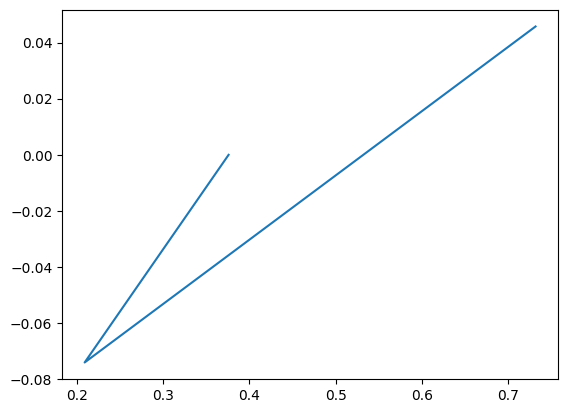

In [25]:
plt.plot(positions[0][:,0].numpy(), positions[0][:,1].numpy())

In [26]:
speeds = p._get_speeds(positions)
headings = p._get_headings(positions)

In [27]:
def plot_heading_speed_diagnostic(dataset_idx, IDX):
    "Requires position, heading, and speed arrays prebuilt"
    features = list(dataset[dataset_idx]['feats'])
    ctrs = list(dataset[dataset_idx]['ctrs'])
    features = torch.tensor(features)
    
    ACTORS, STEPS, _ = features.shape
    positions = [[(features[actor_idx,timestep,0],
                   features[actor_idx,timestep,1]) for timestep in range(-5,0,1)] for actor_idx in range(features.shape[0])]
    positions = torch.tensor(positions)
    speeds = p._get_speeds(positions)
    
    headings = p._get_headings(positions)
    
    fig, axs = plt.subplots(1, 1)
    segments = positions[IDX].numpy()
    segments = np.array([[segments[i],segments[i+1]] for i in range(segments.shape[0]-1)])
    norm = plt.Normalize(0, segments.shape[0]-1)
    lc = LineCollection(segments, cmap='winter', norm=norm)
    lc.set_array(np.arange(positions[IDX].shape[0]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs, orientation='horizontal')
    axs.set_xlim(positions[IDX][:,0].min()-0.1, positions[IDX][:,0].max()+0.1)
    axs.set_ylim(positions[IDX][:,1].min()-0.1, positions[IDX][:,1].max()+0.1)
    axs.arrow(positions[IDX][-1,0], positions[IDX][-1,1],
              0.01*speeds[IDX]*np.cos(headings[IDX]), 0.01*speeds[IDX]*np.sin(headings[IDX]),
              color='red', width=0.005)
    axs.scatter(positions[IDX][-1,0], positions[IDX][-1,1], marker="x")
    axs.annotate("FIRST", (positions[IDX][0,0], positions[IDX][0,1]),
                 xytext=(4,4), textcoords="offset points") 
    axs.scatter(positions[IDX][0,0], positions[IDX][0,1], marker="x")
    axs.annotate("LAST", (positions[IDX][-1,0], positions[IDX][-1,1]),
                 xytext=(4,4), textcoords="offset points") 
    axs.set_aspect('equal')
    plt.title(f"IDX: {IDX}|Speed: {speeds[IDX]:.4f}|Angle: {headings[IDX]:.4f}|Traces:{segments.shape[0]}")
    plt.show()

In [28]:
dataset[0]['feats'].shape

(15, 20, 3)

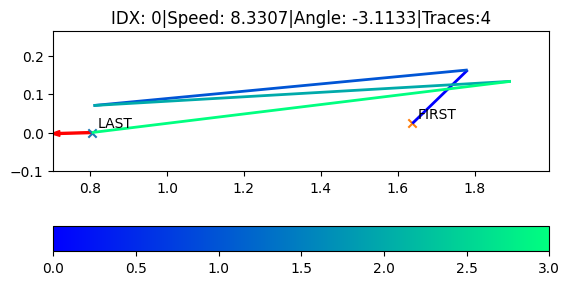

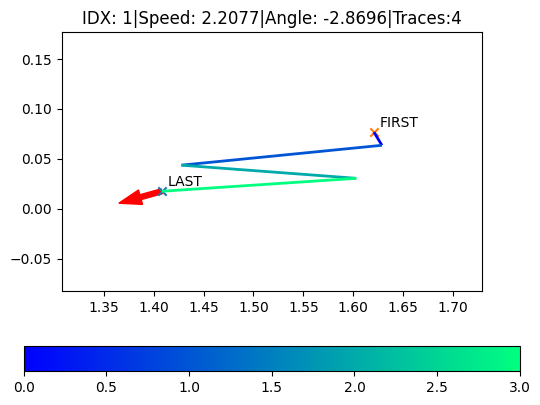

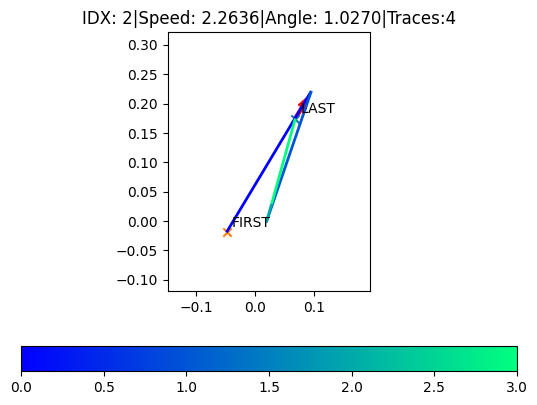

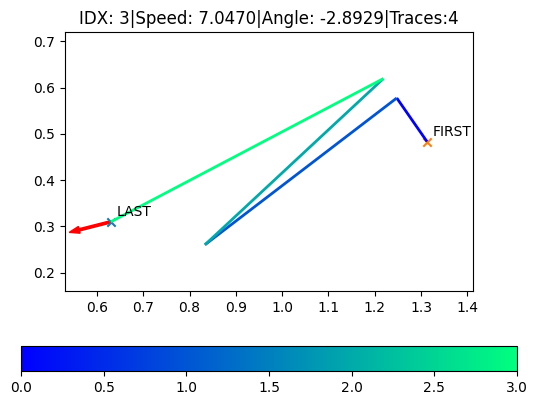

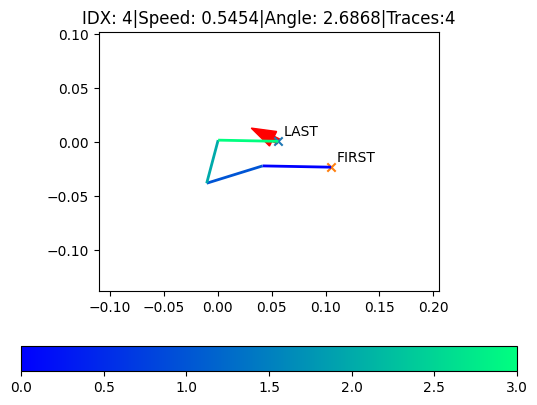

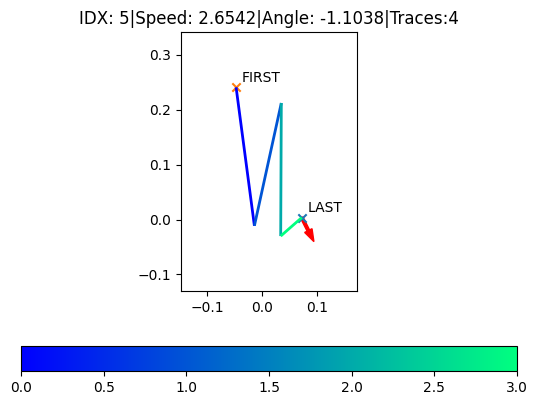

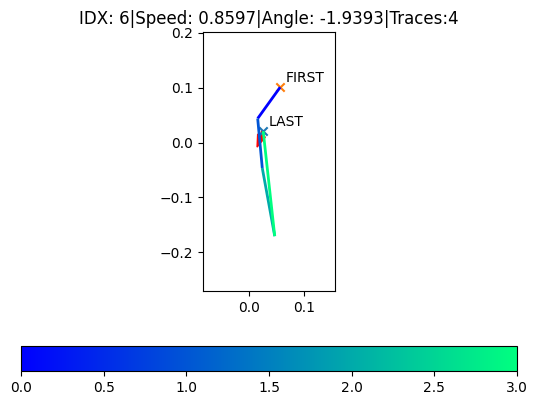

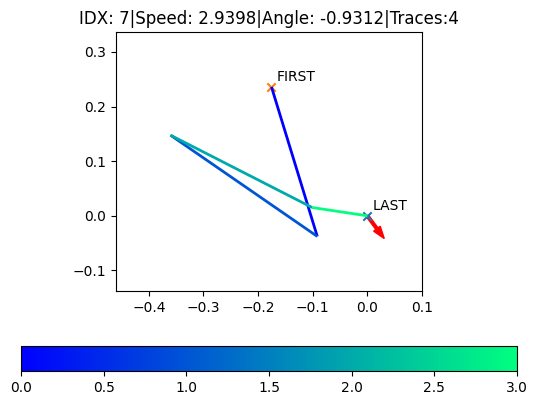

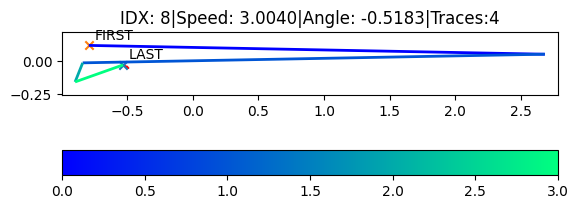

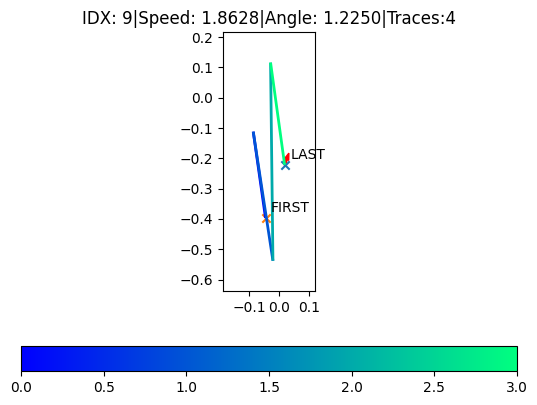

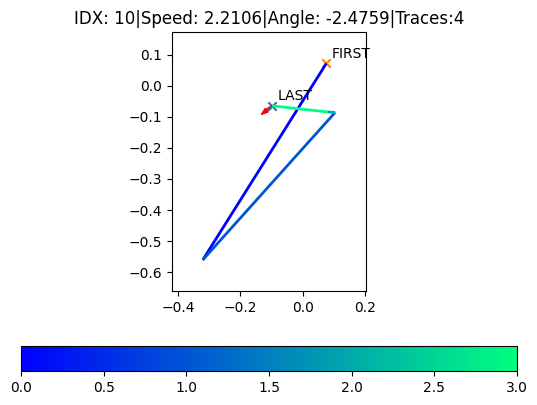

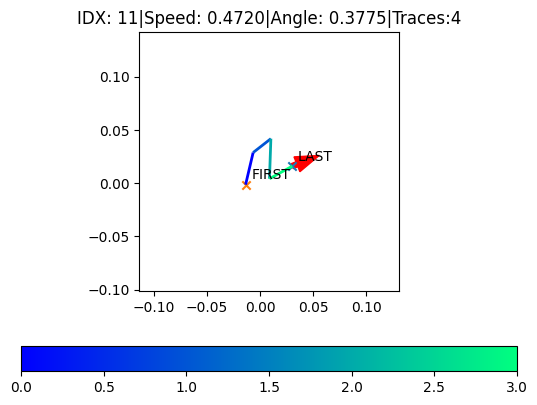

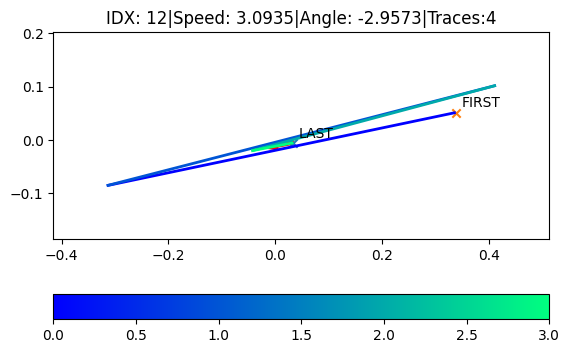

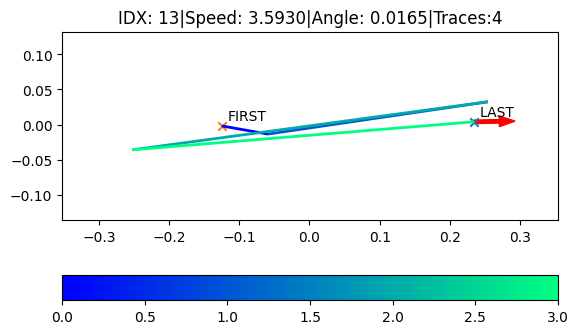

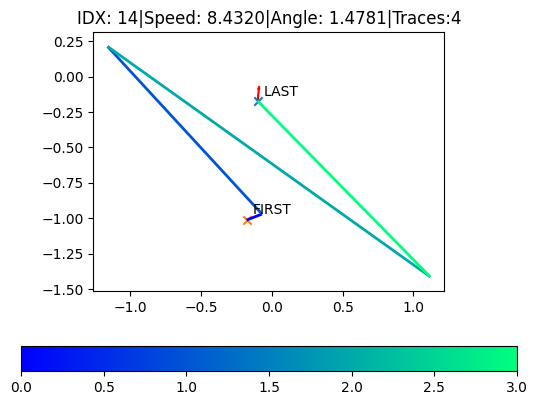

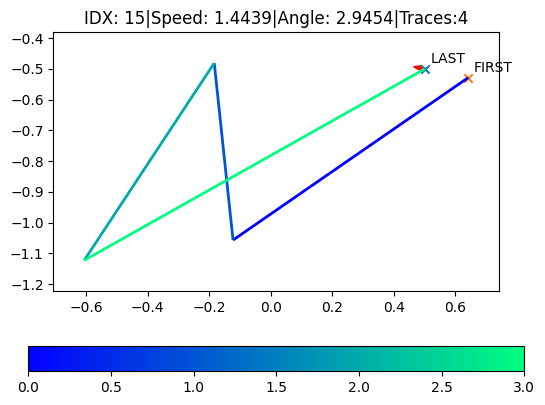

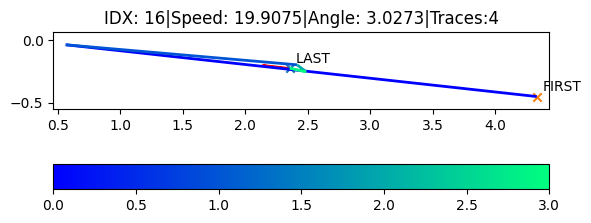

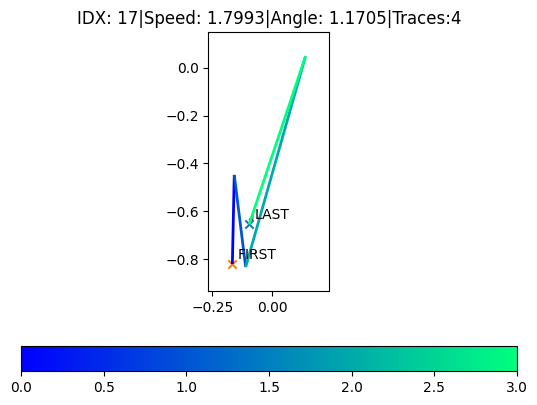

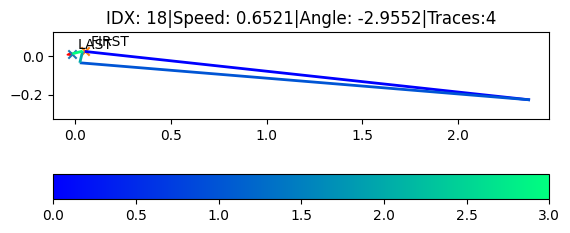

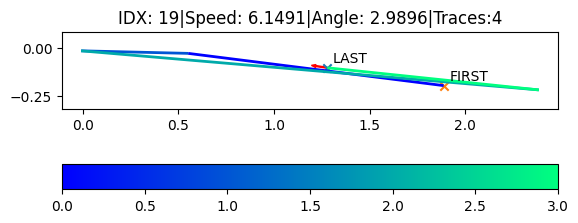

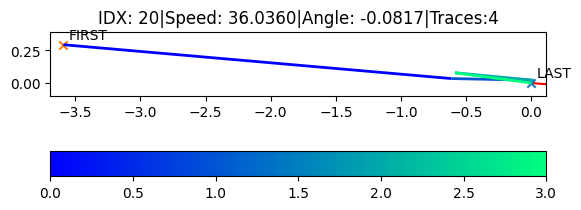

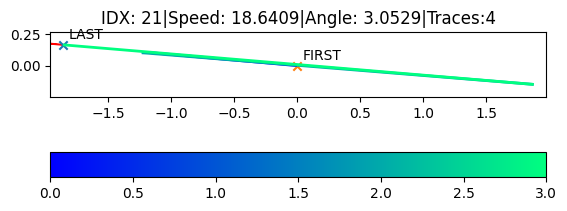

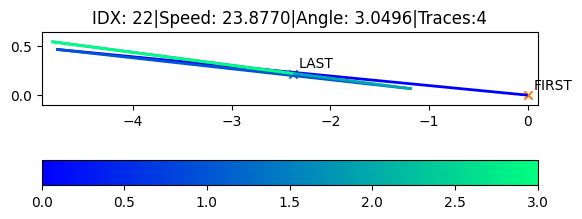

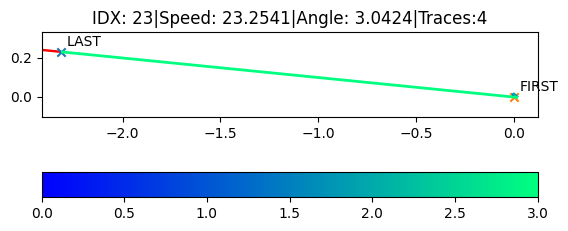

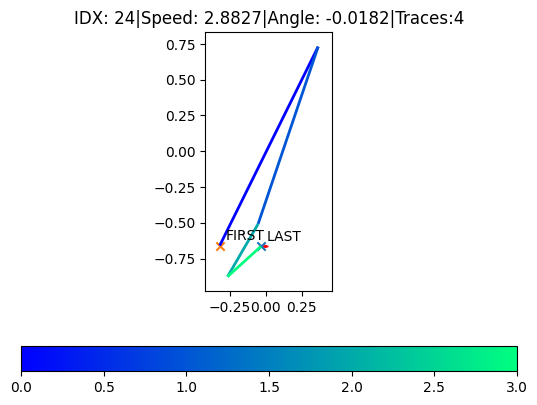

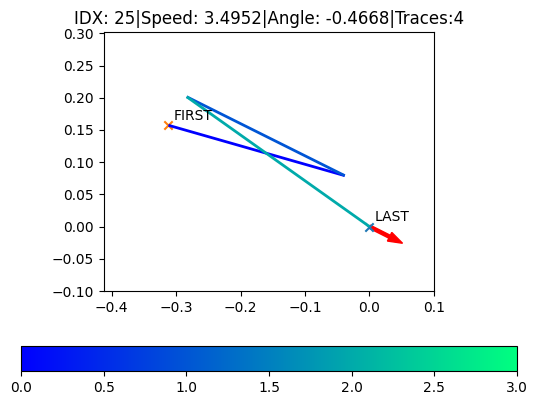

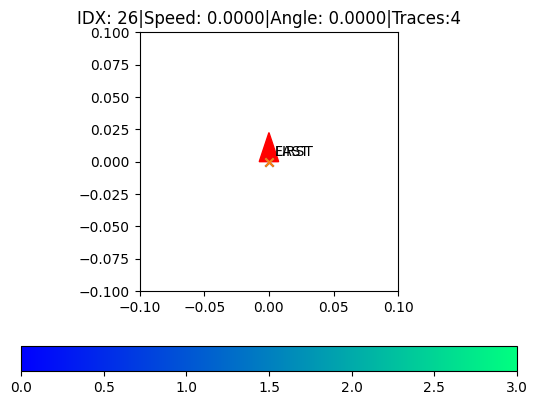

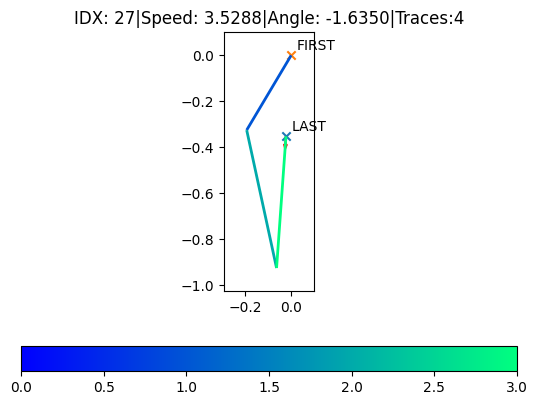

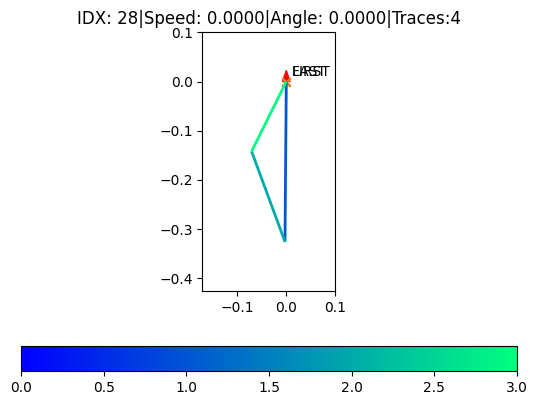

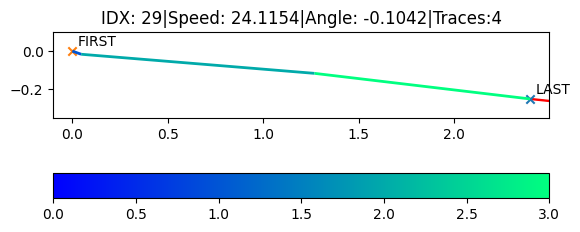

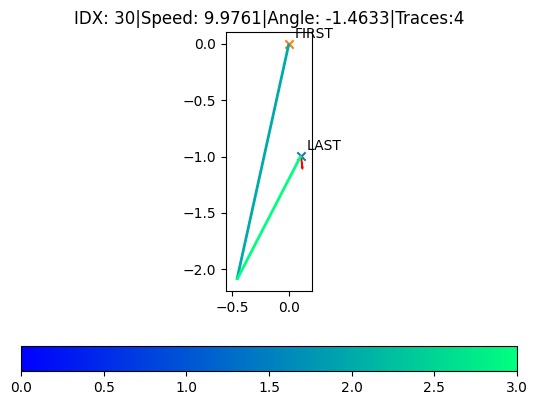

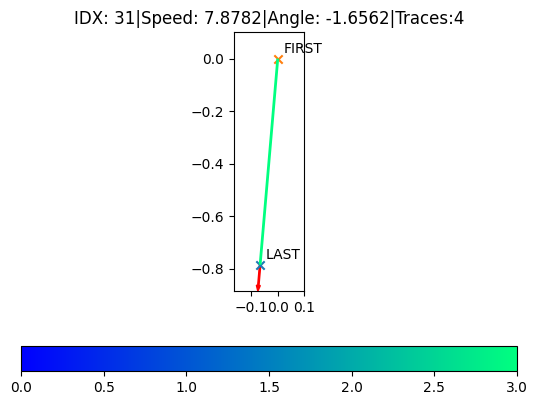

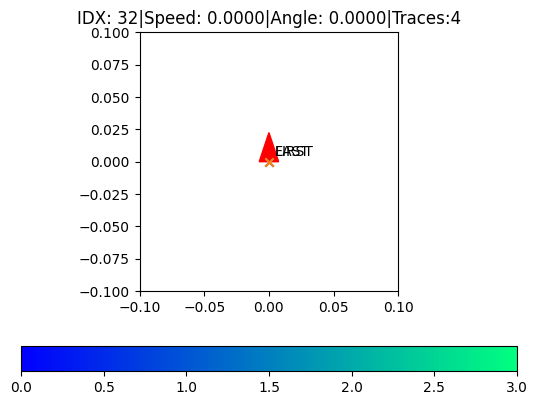

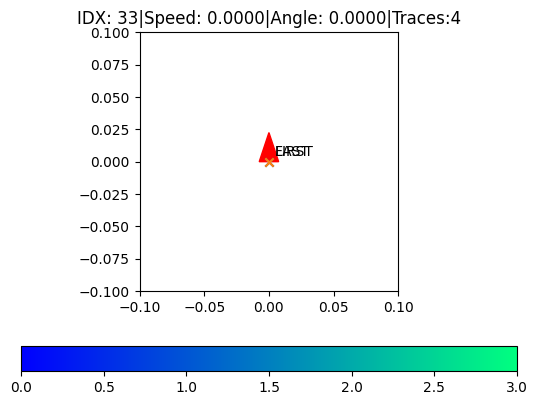

In [29]:
dataset_idx = 32
for IDX in range(dataset[dataset_idx]['feats'].shape[0]):
    plot_heading_speed_diagnostic(dataset_idx, IDX)

In [33]:
dataset[dataidx]['has_preds'].shape

(33, 30)

In [37]:

from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import Sampler, DataLoader

In [46]:
train_sampler = DistributedSampler(
        dataset, num_replicas=1, rank=0
    )

In [47]:
def worker_init_fn(pid):
    np_seed = hvd.rank() * 1024 + int(pid)
    np.random.seed(np_seed)
    random_seed = np.random.randint(2 ** 32 - 1)
    random.seed(random_seed)

In [48]:
train_loader = DataLoader(
        dataset,
        batch_size=config["batch_size"],
        num_workers=config["workers"],
        sampler=train_sampler,
        collate_fn=collate_fn,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        drop_last=True,
    )

In [49]:
len(train_loader)

1233